# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

sns.set(style="darkgrid")

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Datasets

In [2]:
df = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa.csv', sep=',')
df2 = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa (4).csv', sep=',')

In [3]:
df = pd.concat([df, df2], ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5600 non-null   object 
 1   Último    5600 non-null   float64
 2   Abertura  5600 non-null   float64
 3   Máxima    5600 non-null   float64
 4   Mínima    5600 non-null   float64
 5   Vol.      5599 non-null   object 
 6   Var%      5600 non-null   object 
dtypes: float64(4), object(3)
memory usage: 306.4+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Último,5600.0,58.756236,30.994318,8.371,37.39375,56.3830,74.2975,130.776
Abertura,5600.0,58.738725,30.988652,8.397,37.37775,56.3830,74.1915,130.776
Máxima,5600.0,59.338987,31.237257,8.513,37.88950,56.9400,74.9755,131.190
Mínima,5600.0,58.143359,30.735579,8.225,36.82550,55.7965,73.1335,129.526


# Tratamento dos Dados

In [6]:
df.loc[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1258,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [7]:
df = df.dropna()
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [8]:
df['Var%'] = df['Var%'].str.replace("%", "")
df['Var%'] = df['Var%'].str.replace(",", ".")
df['Var%'] = df['Var%'].astype(float)

In [9]:
df['Vol.'] = df['Vol.'].str.replace(',', '.')

In [10]:
for _, row in df.iterrows():
    value = row['Vol.']
    try:
        if value[-1] == 'M':
            value = value.replace('M', '')
            value = float(value) * 1_000_000
        elif value[-1] == 'K':
            value = value.replace('K', '')
            value = float(value) * 1_000_00
        else:
            print('ERRO :', value)
            break
    except TypeError:
        print(value)
    df.loc[df.index == _, 'Vol.'] = value

In [11]:
df['Vol.'] = round(df['Vol.'].astype(float))

In [12]:
# Convertendo variável 'Data' de object para Datetime
df['Data'] = df['Data'].str.replace('.', '-')
df['Data'] = pd.to_datetime(df['Data'], format="%d-%m-%Y")

In [13]:
df = df.set_index(df['Data'])

In [14]:
df = df.drop(columns=['Data'])

In [15]:
df = df.loc[df.index.year > 2010]

In [16]:
df.shape

(3120, 6)

# Análise Exploratória de Dados

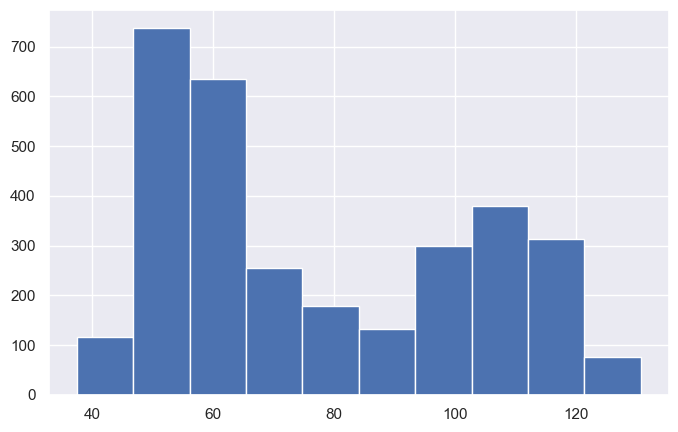

In [17]:
plt.figure(figsize=(8,5))
plt.hist(df['Último'])
plt.show()

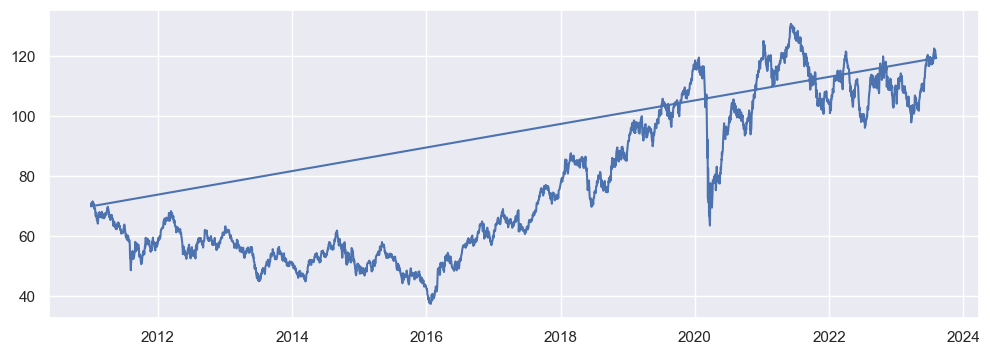

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df.index, df.Último)
plt.show()

In [19]:
df = df.sort_index()

In [20]:
df_decomposed = df[['Último']]
df_decomposed = df_decomposed.dropna()
df_decomposed = df_decomposed.sort_index()

In [21]:
df_decomposed.head()

,Último
Data,
2011-01-03,69.962
2011-01-04,70.318
2011-01-05,71.091
2011-01-06,70.579
2011-01-07,70.057


In [22]:
resultados = seasonal_decompose(df_decomposed['Último'], period=5)

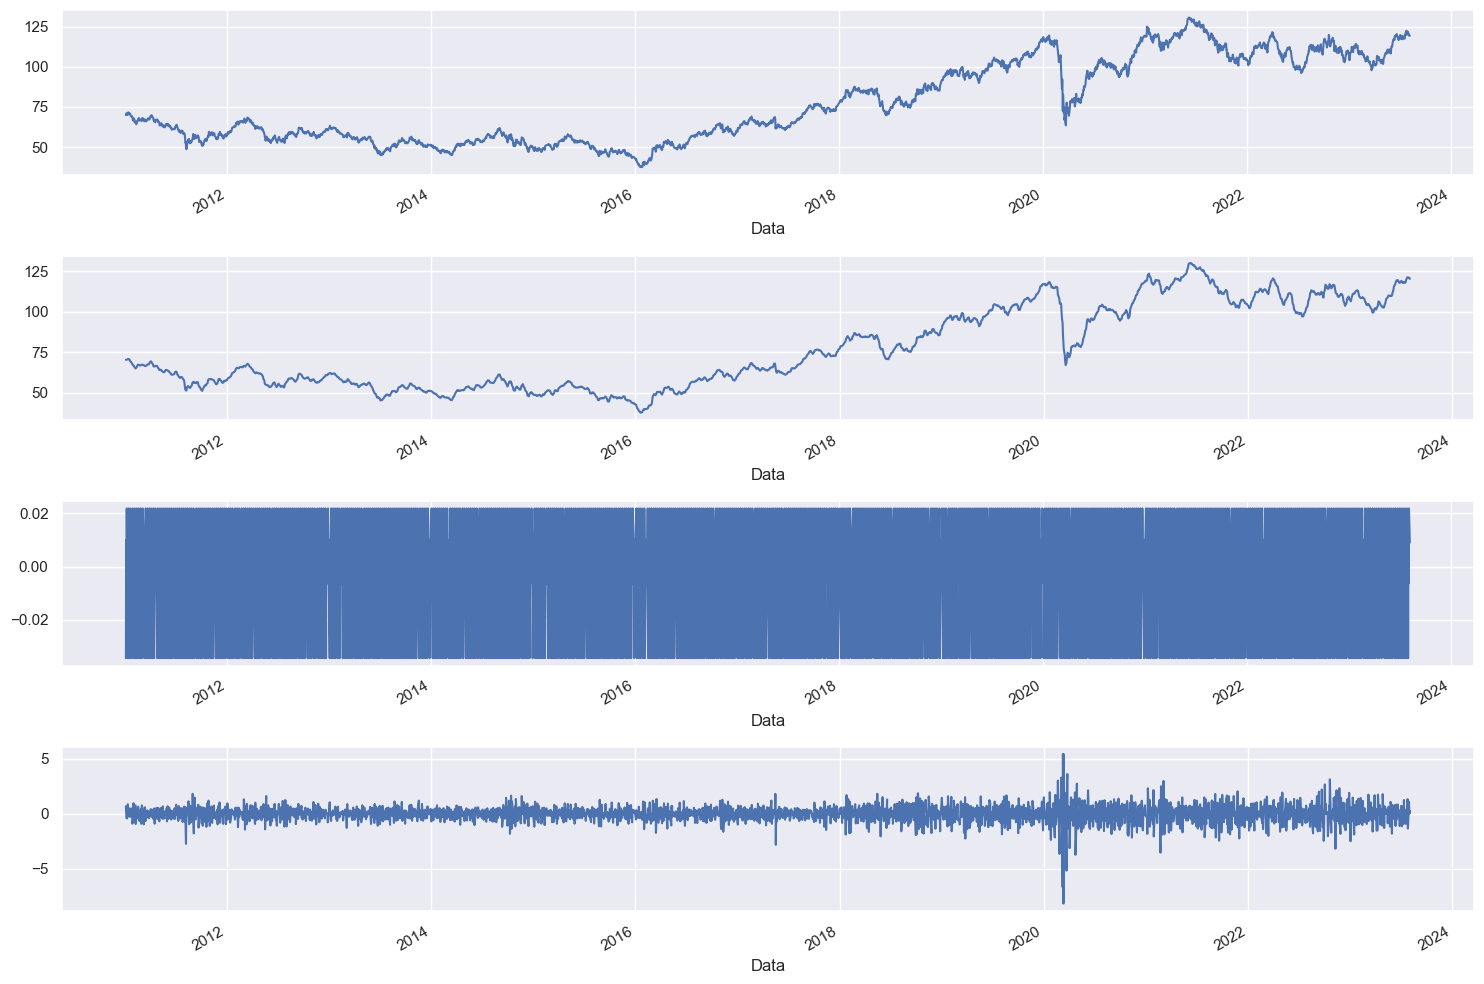

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Conforme analisamos acima, os dados não são estacionários. Veremos a seguir como transformar os novos dados para que se tornem estacionários

In [24]:
X = df_decomposed.Último.values

In [25]:
result = adfuller(X)

In [26]:
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print(f"Valores Críticos:")

for key, value in result[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -0.8438782149908749
P-Value: 0.8058923002307912
Valores Críticos:
	1%: -3.4324530533936075
	5%: -2.8624691981601122
	10%: -2.5672646345228025


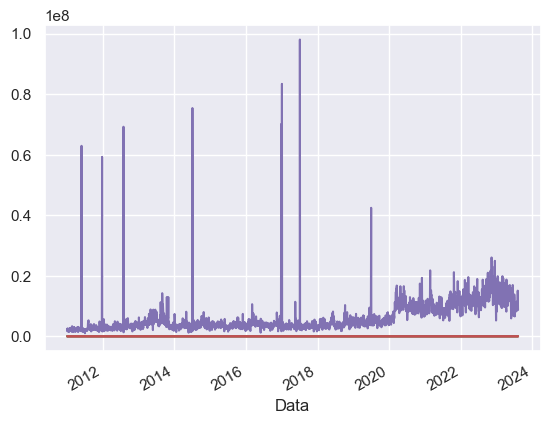

In [27]:
ma = df_decomposed.rolling(5).mean()
f, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.show()

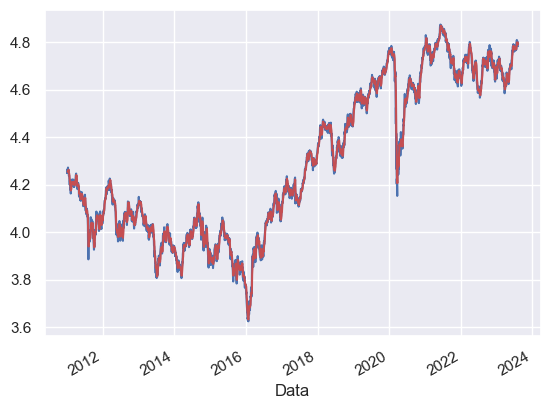

In [28]:
df_log = np.log(df_decomposed)
ma_log = df_log.rolling(5).mean()
f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.show()

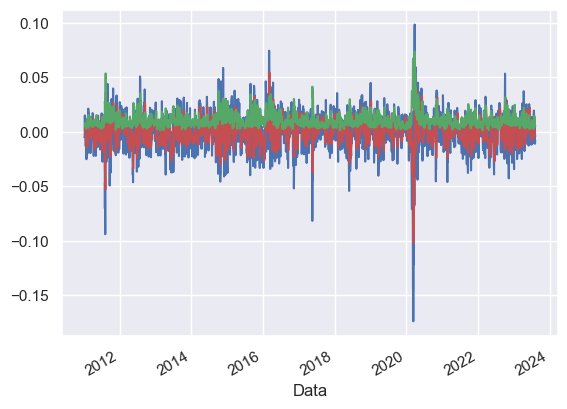

In [29]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(5).mean()
std  = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.show()

In [30]:
X_s = df_s.Último.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -15.48452981945248
P-Value: 2.53088804316872e-28
Valores Críticos:
	1%: -3.4324564405753653
	5%: -2.8624706941992475
	10%: -2.5672654309905196


In [ ]:
# df_diff = df_s.diff(1)
# ma_diff = df_diff.rolling(5).mean()
# std_diff = df_diff.rolling(5).std()

# f, ax = plt.subplots()
# df_diff.plot(ax=ax, legend=False)
# ma_diff.plot(ax=ax, legend=False, color='r')
# std_diff.plot(ax=ax, legend=False, color='g')
# plt.tight_layout()

# X_diff = df_diff.Último.dropna().values

# result_diff = adfuller(X_diff)

# print("Teste ADF")
# print(f"Teste Estatístico: {result_diff[0]}")
# print(f"P-Value: {result_diff[1]}")
# print(f"Valores Críticos:")

# for key, value in result_diff[4].items():
#     print(f"\t{key}: {value}")

In [31]:
lag_acf = acf(df_s.dropna(), nlags=25)
lag_pacf = pacf(df_s.dropna(), nlags=25)

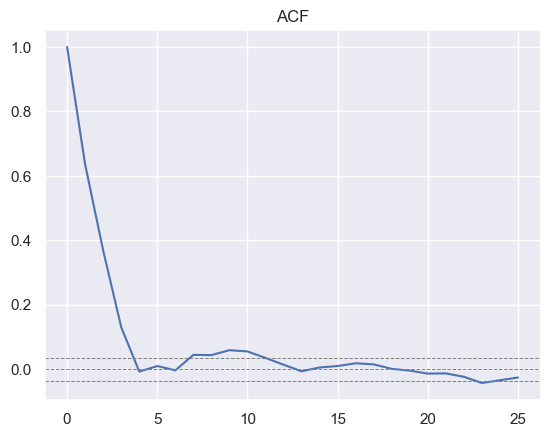

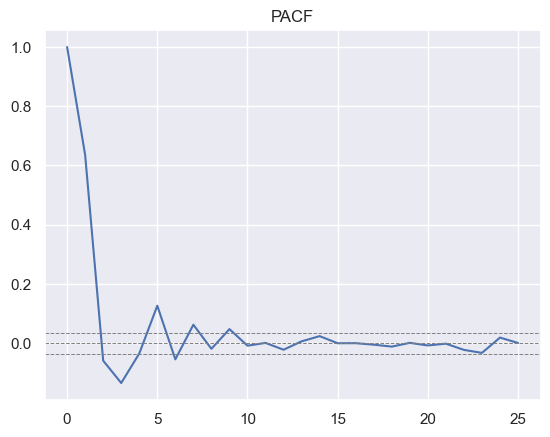

In [33]:
plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

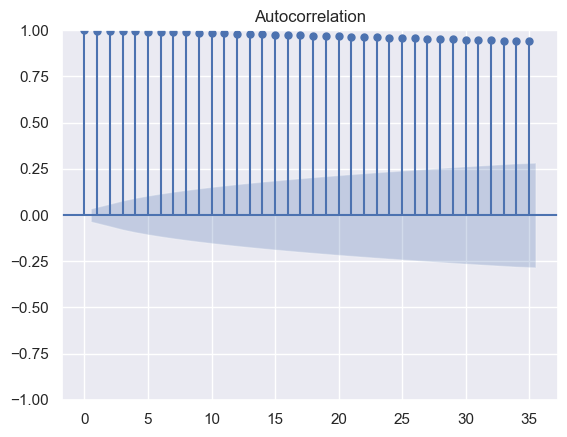

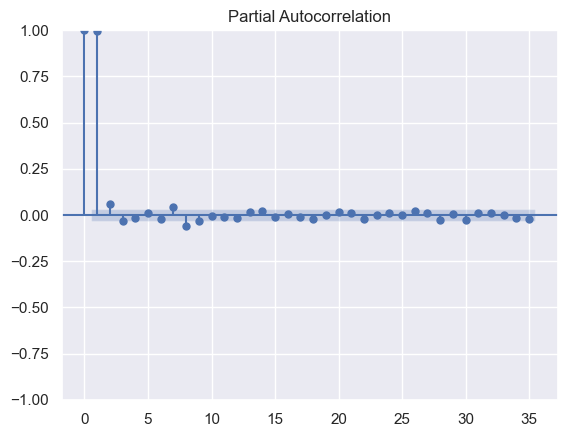

In [34]:
plot_acf(df_decomposed.Último)
plot_pacf(df_decomposed.Último)
plt.show()

In [35]:
df_x = df_s.reset_index()
df_x['unique_id'] = 'Ibovespa'
df_x = df_x.rename(columns={"Data": "ds", "Último": "y"})
df_x

,ds,y,unique_id
0,2011-01-07,-0.004887,Ibovespa
1,2011-01-10,-0.004360,Ibovespa
2,2011-01-11,-0.000446,Ibovespa
3,2011-01-12,0.015071,Ibovespa
4,2011-01-13,0.001855,Ibovespa
...,...,...,...
3111,2023-08-01,0.000548,Ibovespa
3112,2023-08-02,0.000130,Ibovespa
3113,2023-08-03,-0.003122,Ibovespa
3114,2023-08-04,-0.010969,Ibovespa


In [50]:
treino = df_x.loc[(df_x['ds'] < '2023-01-01')]
valid  = df_x.loc[(df_x['ds'] >= '2023-01-01') & (df_x['ds'] < '2023-05-13')]
h = valid['ds'].nunique()

In [51]:
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [52]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

forecast_df = model.predict(h=90, level=[90])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

WMAPE: nan%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [55]:
forecast_df.head(20)

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,Ibovespa,2022-12-30,0.0031,-0.020215,0.026415,NaN
1,Ibovespa,2022-12-31,0.0031,-0.029872,0.036072,NaN
2,Ibovespa,2023-01-01,0.0031,-0.037283,0.043483,NaN
3,Ibovespa,2023-01-02,0.0031,-0.043530,0.049730,-0.021838
4,Ibovespa,2023-01-03,0.0031,-0.049034,0.055234,-0.034241
5,Ibovespa,2023-01-04,0.0031,-0.054010,0.060210,-0.017024
6,Ibovespa,2023-01-05,0.0031,-0.058586,0.064786,0.009407
7,Ibovespa,2023-01-06,0.0031,-0.062845,0.069045,0.023033
8,Ibovespa,2023-01-07,0.0031,-0.066845,0.073045,NaN
9,Ibovespa,2023-01-08,0.0031,-0.070629,0.076828,NaN


KeyError: 'Naive-lo-10'

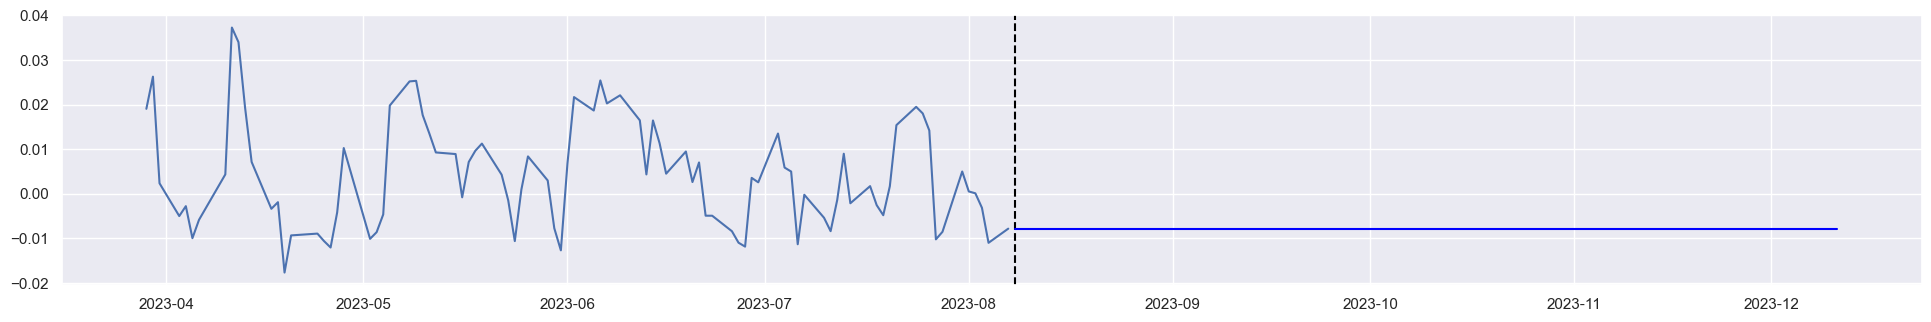

In [45]:
model.plot(treino, forecast_df, level=[10], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=90)

In [ ]:
model_a = StatsForecast(models=[AutoARIMA(season_length=5)], freq='C',n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[90])
#forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

#wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
#print(f"WMAPE: {wmape4:.2%}")

In [ ]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

In [ ]:
model_a.plot(treino, forecast_dfa, level=[90], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=90)

In [ ]:
df.index.sort_values()